In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [ ]:
from sys import path
path.append('/home/adb/PycharmProjects/')

# Import functions for the convolution matrix
from starships.homemade import get_c_matrix, gaussians, fwhm2sigma

**All necessary functions are also available in the commented bloc below**

In [5]:
# # ==============================================================================
# # Code for building the convolution matrix (c matrix).
# # ==============================================================================


# from scipy.sparse import find, diags, csr_matrix
# import logging

# log = logging.getLogger(__name__)
# log.setLevel(logging.DEBUG)

# def gaussians(x, x0, sig, amp=None):
#     """Gaussian function
#     Parameters
#     ----------
#     x : array[float]
#         Array of points over which gaussian to be defined.
#     x0 : float
#         Center of the gaussian.
#     sig : float
#         Standard deviation of the gaussian.
#     amp : float
#         Value of the gaussian at the center.
#     Returns
#     -------
#     values : array[float]
#         Array of gaussian values for input x.
#     """

#     # Amplitude term
#     if amp is None:
#         amp = 1. / np.sqrt(2. * np.pi * sig**2.)

#     values = amp * np.exp(-0.5 * ((x - x0) / sig) ** 2.)

#     return values


# def fwhm2sigma(fwhm):
#     """Convert a full width half max to a standard deviation, assuming a gaussian
#     Parameters
#     ----------
#     fwhm : float
#         Full-width half-max of a gaussian.
#     Returns
#     -------
#     sigma : float
#         Standard deviation of a gaussian.
#     """

#     sigma = fwhm / np.sqrt(8. * np.log(2.))

#     return sigma


# def to_2d(kernel, grid_range):
#     """ Build a 2d kernel array with a constant 1D kernel (input)
#     Parameters
#     ----------
#     kernel : array[float]
#         Input 1D kernel.
#     grid_range : list[int]
#         Indices over which convolution is defined on grid.
#     Returns
#     -------
#     kernel_2d : array[float]
#         2D array of input 1D kernel tiled over axis with
#         length equal to difference of grid_range values.
#     """

#     # Assign range where the convolution is defined on the grid
#     a, b = grid_range

#     # Get length of the convolved axis
#     n_k_c = b - a

#     # Return a 2D array with this length
#     kernel_2d = np.tile(kernel, (n_k_c, 1)).T

#     return kernel_2d


# def _get_wings(fct, grid, h_len, i_a, i_b):
#     """Compute values of the kernel at grid[+-h_len]
#     Parameters
#     ----------
#     fct : callable
#         Function that returns the value of the kernel, given
#         a grid value and the center of the kernel.
#         fct(grid, center) = kernel
#         grid and center have the same length.
#     grid : array[float]
#         grid where the kernel is projected
#     h_len : int
#         Half-length where we compute kernel value.
#     i_a : int
#         Index of grid axis 0 where to apply convolution.
#         Once the convolution applied, the convolved grid will be
#         equal to grid[i_a:i_b].
#     i_b : int
#         index of grid axis 1 where to apply convolution.
#     Returns
#     -------
#     left : array[float]
#         Kernel values at left wing.
#     right : array[float]
#         Kernel values at right wing.
#     """

#     # Save length of the non-convolved grid
#     n_k = len(grid)

#     # Get length of the convolved axis
#     n_k_c = i_b - i_a

#     # Init values
#     left, right = np.zeros(n_k_c), np.zeros(n_k_c)

#     # Add the left value on the grid
#     # Possibility that it falls out of the grid;
#     # take first value of the grid if so.
#     i_grid = np.max([0, i_a - h_len])

#     # Save the new grid
#     grid_new = grid[i_grid:i_b - h_len]

#     # Re-use dummy variable `i_grid`
#     i_grid = len(grid_new)

#     # Compute kernel at the left end.
#     # `i_grid` accounts for smaller length.
#     ker = fct(grid_new, grid[i_b - i_grid:i_b])
#     left[-i_grid:] = ker

#     # Add the right value on the grid
#     # Possibility that it falls out of the grid;
#     # take last value of the grid if so.
#     # Same steps as the left end (see above)
#     i_grid = np.min([n_k, i_b + h_len])
#     grid_new = grid[i_a + h_len:i_grid]
#     i_grid = len(grid_new)
#     ker = fct(grid_new, grid[i_a:i_a + i_grid])
#     right[:i_grid] = ker

#     return left, right


# def trpz_weight(grid, length, shape, i_a, i_b):
#     """Compute weights due to trapezoidal integration
#     Parameters
#     ----------
#     grid : array[float]
#         grid where the integration is projected
#     length : int
#         length of the kernel
#     shape : tuple[int]
#         shape of the compact convolution 2d array
#     i_a : int
#         Index of grid axis 0 where to apply convolution.
#         Once the convolution applied, the convolved grid will be
#         equal to grid[i_a:i_b].
#     i_b : int
#         index of grid axis 1 where to apply convolution.
#     Returns
#     -------
#     out : array[float]
#         2D array with shape according to input shape
#     """

#     # Index of each element on the convolution matrix
#     # with respect to the non-convolved grid
#     # `i_grid` has the shape (N_k_convolved, kernel_length - 1)
#     i_grid = np.indices(shape)[0] - (length // 2)
#     i_grid = np.arange(i_a, i_b)[None, :] + i_grid[:-1, :]

#     # Set values out of grid to -1
#     i_bad = (i_grid < 0) | (i_grid >= len(grid) - 1)
#     i_grid[i_bad] = -1

#     # Delta lambda
#     d_grid = np.diff(grid)

#     # Compute weights from trapezoidal integration
#     weight = 0.5 * d_grid[i_grid]
#     weight[i_bad] = 0

#     # Fill output
#     out = np.zeros(shape)
#     out[:-1] += weight
#     out[1:] += weight

#     return out


# def fct_to_array(fct, grid, grid_range, thresh=1e-5, length=None):
#     """Build a compact kernel 2d array based on a kernel function
#     and a grid to project the kernel
#     Parameters
#     ----------
#     fct : callable
#         Function that returns the value of the kernel, given
#         a grid value and the center of the kernel.
#         fct(grid, center) = kernel
#         grid and center have the same length.
#     grid : array[float]
#         Grid where the kernel is projected
#     grid_range : list[int] or tuple[int]
#         Indices of the grid where to apply the convolution.
#         Once the convolution applied, the convolved grid will be
#         equal to grid[grid_range[0]:grid_range[1]].
#     thresh : float, optional
#         Threshold to cut the kernel wings. If `length` is specified,
#         `thresh` will be ignored.
#     length : int, optional
#         Length of the kernel. Must be odd.
#     Returns
#     -------
#     kern_array : array[float]
#         2D array of kernel projected onto grid.
#     """

#     # Assign range where the convolution is defined on the grid
#     i_a, i_b = grid_range

#     # Init with the value at kernel's center
#     out = fct(grid, grid)[i_a:i_b]

#     # Add wings
#     if length is None:
#         # Generate a 2D array of the grid iteratively until
#         # thresh is reached everywhere.

#         # Init parameters
#         length = 1
#         h_len = 0  # Half length

#         # Add value on each sides until thresh is reached
#         while True:
#             # Already update half-length
#             h_len += 1

#             # Compute next left and right ends of the kernel
#             left, right = _get_wings(fct, grid, h_len, i_a, i_b)

#             # Check if they are all below threshold.
#             if (left < thresh).all() and (right < thresh).all():
#                 break  # Stop iteration
#             else:
#                 # Update kernel length
#                 length += 2

#                 # Set value to zero if smaller than threshold
#                 left[left < thresh] = 0.
#                 right[right < thresh] = 0.

#                 # add new values to output
#                 out = np.vstack([left, out, right])

#         # Weights due to integration (from the convolution)
#         weights = trpz_weight(grid, length, out.shape, i_a, i_b)

#     elif (length % 2) == 1:  # length needs to be odd
#         # Generate a 2D array of the grid iteratively until
#         # specified length is reached.

#         # Compute number of half-length
#         n_h_len = (length - 1) // 2

#         # Simply iterate to compute needed wings
#         for h_len in range(1, n_h_len + 1):
#             # Compute next left and right ends of the kernel
#             left, right = _get_wings(fct, grid, h_len, i_a, i_b)

#             # Add new kernel values
#             out = np.vstack([left, out, right])

#         # Weights due to integration (from the convolution)
#         weights = trpz_weight(grid, length, out.shape, i_a, i_b)

#     else:
#         msg = "`length` provided to `fct_to_array` must be odd."
#         log.critical(msg)
#         raise ValueError(msg)

#     kern_array = (out * weights)
#     return kern_array


# def cut_ker(ker, n_out=None, thresh=None):
#     """Apply a cut on the convolution matrix boundaries.
#     Parameters
#     ----------
#     ker : array[float]
#         convolution kernel in compact form, so
#         shape = (N_ker, N_k_convolved)
#     n_out : int, list[int] or tuple[int]
#         Number of kernel's grid point to keep on the boundaries.
#         If an int is given, the same number of points will be
#         kept on each boundaries of the kernel (left and right).
#         If 2 elements are given, it corresponds to the left and right
#         boundaries.
#     thresh : float
#         threshold used to determine the boundaries cut.
#         If n_out is specified, this is ignored.
#     Returns
#     ------
#     ker : array[float]
#         The same kernel matrix as the input ker, but with the cut applied.
#     """

#     # Assign kernel length and number of kernels
#     n_ker, n_k_c = ker.shape

#     # Assign half-length of the kernel
#     h_len = (n_ker - 1) // 2

#     # Determine n_out with thresh if not given
#     if n_out is None:

#         if thresh is None:
#             # No cut to apply
#             return ker
#         else:
#             # Find where to cut the kernel according to thresh
#             i_left = np.where(ker[:, 0] >= thresh)[0][0]
#             i_right = np.where(ker[:, -1] >= thresh)[0][-1]

#             # Make sure it is on the good wing. Take center if not.
#             i_left = np.minimum(i_left, h_len)
#             i_right = np.maximum(i_right, h_len)

#     # Else, unpack n_out
#     else:
#         # Could be a scalar or a 2-elements object)
#         try:
#             i_left, i_right = n_out
#         except TypeError:
#             i_left, i_right = n_out, n_out

#         # Find the position where to cut the kernel
#         # Make sure it is not out of the kernel grid,
#         # so i_left >= 0 and i_right <= len(kernel)
#         i_left = np.maximum(h_len - i_left, 0)
#         i_right = np.minimum(h_len + i_right, n_ker - 1)

#     # Apply the cut
#     for i_k in range(0, i_left):
#         # Add condition in case the kernel is larger
#         # than the grid where it's projected.
#         if i_k < n_k_c:
#             ker[:i_left - i_k, i_k] = 0

#     for i_k in range(i_right + 1 - n_ker, 0):
#         # Add condition in case the kernel is larger
#         # than the grid where it's projected.
#         if -i_k <= n_k_c:
#             ker[i_right - n_ker - i_k:, i_k] = 0

#     return ker


# def sparse_c(ker, n_k, i_zero=0):
#     """Convert a convolution kernel in compact form (N_ker, N_k_convolved)
#     to sparse form (N_k_convolved, N_k)
#     Parameters
#     ----------
#     ker : array[float]
#         Convolution kernel in compact form, with shape (N_kernel, N_kc)
#     n_k : int
#         Length of the original grid
#     i_zero : int
#         Position of the first element of the convolved grid
#         in the original grid.
#     Returns
#     -------
#     matrix : array[float]
#         Sparse form of the input convolution kernel
#     """

#     # Assign kernel length and convolved axis length
#     n_ker, n_k_c = ker.shape

#     # Algorithm works for odd kernel grid
#     if n_ker % 2 != 1:
#         err_msg = "Length of the convolution kernel given to sparse_c should be odd."
#         log.critical(err_msg)
#         raise ValueError(err_msg)

#     # Assign half-length
#     h_len = (n_ker - 1) // 2

#     # Define each diagonal of the sparse convolution matrix
#     diag_val, offset = [], []
#     for i_ker, i_k_c in enumerate(range(-h_len, h_len + 1)):

#         i_k = i_zero + i_k_c

#         if i_k < 0:
#             diag_val.append(ker[i_ker, -i_k:])
#         else:
#             diag_val.append(ker[i_ker, :])

#         offset.append(i_k)

#     # Build convolution matrix
#     matrix = diags(diag_val, offset, shape=(n_k_c, n_k), format="csr")

#     return matrix


# def get_c_matrix(kernel, grid, bounds=None, i_bounds=None, norm=True,
#                  sparse=True, n_out=None, thresh_out=None, **kwargs):
#     """Return a convolution matrix
#     Can return a sparse matrix (N_k_convolved, N_k)
#     or a matrix in the compact form (N_ker, N_k_convolved).
#     N_k is the length of the grid on which the convolution
#     will be applied, N_k_convolved is the length of the
#     grid after convolution and N_ker is the maximum length of
#     the kernel. If the default sparse matrix option is chosen,
#     the convolution can be applied on an array f | f = fct(grid)
#     by a simple matrix multiplication:
#     f_convolved = c_matrix.dot(f)
#     Parameters
#     ----------
#     kernel: ndarray (1D or 2D), callable
#         Convolution kernel. Can be already 2D (N_ker, N_k_convolved),
#         giving the kernel for each items of the convolved grid.
#         Can be 1D (N_ker), so the kernel is the same. Can be a callable
#         with the form f(x, x0) where x0 is the position of the center of
#         the kernel. Must return a 1D array (len(x)), so a kernel value
#         for each pairs of (x, x0). If kernel is callable, the additional
#         kwargs `thresh` and `length` will be used to project the kernel.
#     grid: one-d-array:
#         The grid on which the convolution will be applied.
#         For example, if C is the convolution matrix,
#         f_convolved = C.f(grid)
#     bounds: 2-elements object
#         The bounds of the grid on which the convolution is defined.
#         For example, if bounds = (a,b),
#         then grid_convolved = grid[a <= grid <= b].
#         It dictates also the dimension of f_convolved
#     sparse: bool, optional
#         return a sparse matrix (N_k_convolved, N_k) if True.
#         return a matrix (N_ker, N_k_convolved) if False.
#     n_out: integer or 2-integer object, optional
#         Specify how to deal with the ends of the convolved grid.
#         `n_out` points will be used outside from the convolved
#         grid. Can be different for each ends if 2-elements are given.
#     thresh_out: float, optional
#         Specify how to deal with the ends of the convolved grid.
#         Points with a kernel value less then `thresh_out` will
#         not be used outside from the convolved grid.
#     thresh: float, optional
#         Only used when `kernel` is callable to define the maximum
#         length of the kernel. Truncate when `kernel` < `thresh`
#     length: int, optional
#         Only used when `kernel` is callable to define the maximum
#         length of the kernel.
#     """

#     # Define range where the convolution is defined on the grid.
#     # If `i_bounds` is not specified, try with `bounds`.
#     if i_bounds is None:

#         if bounds is None:
#             a, b = 0, len(grid)
#         else:
#             a = np.min(np.where(grid >= bounds[0])[0])
#             b = np.max(np.where(grid <= bounds[1])[0]) + 1

#     else:
#         # Make sure it is absolute index, not relative
#         # So no negative index.
#         if i_bounds[1] < 0:
#             i_bounds[1] = len(grid) + i_bounds[1]

#         a, b = i_bounds

#     # Generate a 2D kernel depending on the input
#     if callable(kernel):
#         kernel = fct_to_array(kernel, grid, [a, b], **kwargs)
#     elif kernel.ndim == 1:
#         kernel = to_2d(kernel, [a, b])

#     if kernel.ndim != 2:
#         msg = ("Input kernel to get_c_matrix must be callable or"
#                " array with one or two dimensions.")
#         log.critical(msg)
#         raise ValueError(msg)
#     # Kernel should now be a 2-D array (N_kernel x N_kc)

#     # Normalize if specified
#     if norm:
#         kernel = kernel / np.nansum(kernel, axis=0)

#     # Apply cut for kernel at boundaries
#     kernel = cut_ker(kernel, n_out, thresh_out)

#     if sparse:
#         # Convert to a sparse matrix.
#         kernel = sparse_c(kernel, len(grid), a)

#     return kernel

# Create the convolution matrix

- Need to know the kernel shape as a function of wavelength or array position
- In this example, the kernel shape is a gaussian with varying fwhm as a function of pixel position

In [35]:
pad = 10  # Add a pad at the borders to avoid borders effects
n_pix = 4096
pix_idx = np.arange(-pad, n_pix + pad)

def fct_fwhm(central_pixel):
    return 2 + central_pixel/10000 + (central_pixel/3000)**2

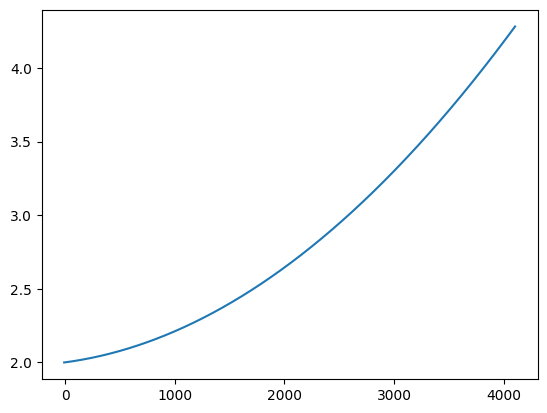

In [36]:
plt.plot(pix_idx, fct_fwhm(pix_idx))

## Define the kernel function

In [37]:
def fct_ker(pix, pix_center):
    
    fwhm = fct_fwhm(pix_center)
    sigma = fwhm2sigma(fwhm)
    
    out = gaussians(pix, pix_center, sigma)
    
    return out

## Build it

In [38]:
get_c_matrix?

In [39]:
%%time
convolution_matrix = get_c_matrix(fct_ker, pix_idx, bounds=(0, n_pix), thresh=1e-6)

CPU times: user 5.85 ms, sys: 10.1 ms, total: 15.9 ms
Wall time: 38.3 ms


#### Build the convolution matrix in its compact form just for illustration (can be used to saved it as well)

In [46]:
compact_matrix = get_c_matrix(fct_ker, pix_idx, bounds=(0, n_pix), thresh=1e-5, sparse=False)

In [47]:
compact_matrix.shape

(17, 4097)

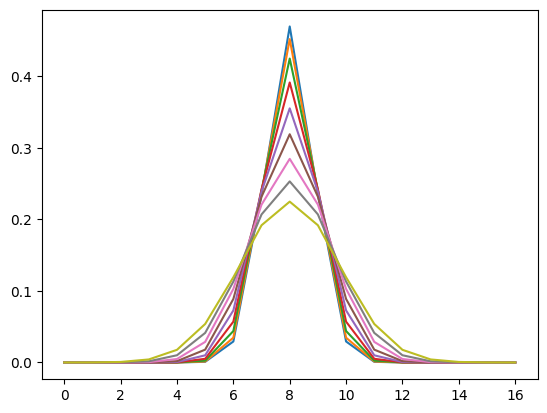

In [48]:
_ = plt.plot(compact_matrix[:, 0::500])

#### Make a fake spectrum to show the effect

In [49]:
line_idx = np.searchsorted(pix_idx, np.arange(100, n_pix-100, 20))
spec = np.zeros_like(pix_idx)
spec[line_idx] = 1

In [50]:
%%time
conv_spec = convolution_matrix.dot(spec)

CPU times: user 0 ns, sys: 3.48 ms, total: 3.48 ms
Wall time: 10.3 ms


(3950.0, 4000.0)

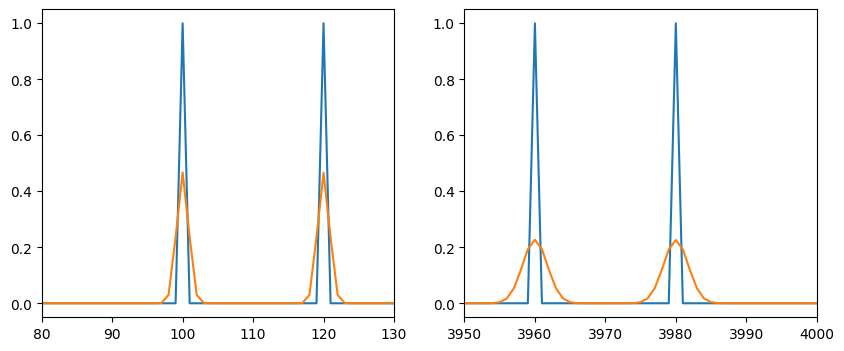

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(pix_idx, spec)
ax[0].plot(conv_spec)
ax[0].set_xlim(80, 130)

ax[1].plot(pix_idx, spec)
ax[1].plot(conv_spec)
ax[1].set_xlim(3950, 4000)